# Import des Netzwerks für das Modell

### Einrichtung

In [1]:
from __future__ import print_function, division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import math

import pypsa

%matplotlib inline

## Setup

Einrichtung aller wichtigen Kompnenten und Einlesen der Daten

Die jeweiligen Daten entstammen einer anderen Bachelorarbeit und werden über die von pandas zur Verfügung gestellten Funktionen aus Excel-Dateien eingelesen und als Dataframe gespeichert. Aus diesem werden dann wiederum nur die benötigten Werte verwendet.

### Variablen

In [2]:
nw = pypsa.Network()

In [3]:
dates = pd.date_range("2015-11-01T04:00:00Z", periods=5, freq="4H")

nw.set_snapshots(dates)

In [4]:
cur_path = r"C:\Users\janni\OneDrive\TU Berlin\4 - Abschlussarbeiten\01 - Bachelorarbeit\modell\data\\"

### Einlesen der Datenbanken

### Knotenpunkte

In [5]:
ex1 = pd.ExcelFile(cur_path + "map_cities.xlsx")
ex2 = pd.ExcelFile(cur_path + "map_countries.xlsx")

all_gens = pd.read_excel(cur_path + "Kraftwerksliste_ÜNB_Entwurf_Szenariorahmen_2030_V2019.xlsx")

In [6]:
df_cities = pd.read_excel(ex1, sheetname="buses", header=0, parse_cols="B:D")
df_countries = pd.read_excel(ex2, sheetname="buses", header=0, parse_cols="B:D")
df_buses = df_cities.append(df_countries).reset_index(drop=True)

C:\Users\janni\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: the 'parse_cols' keyword is deprecated, use 'usecols' instead
  """Entry point for launching an IPython kernel.
C:\Users\janni\Anaconda3\lib\site-packages\pandas\util\_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)
C:\Users\janni\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: the 'parse_cols' keyword is deprecated, use 'usecols' instead
  


In [7]:
pypsa.io.import_components_from_dataframe(nw, df_buses, "Bus")

### Leitungen

In [8]:
df_cities_lines = pd.read_excel(ex1, sheetname="lines", header=0, parse_cols="B:D")
df_countries_lines = pd.read_excel(ex2, sheetname="lines", header=0, parse_cols="B:D")
df_lines = df_cities_lines.append(df_countries_lines).reset_index(drop=True)

C:\Users\janni\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: the 'parse_cols' keyword is deprecated, use 'usecols' instead
  """Entry point for launching an IPython kernel.
C:\Users\janni\Anaconda3\lib\site-packages\pandas\util\_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)
C:\Users\janni\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: the 'parse_cols' keyword is deprecated, use 'usecols' instead
  


Calculating the length of each line by Pythagoras.
The factor enables converting the distance in lattitude/longitude to kilometers

In [9]:
df_lines["length"] = 0
factor_coords_to_km = 111

for i in range(len(df_lines)):
    x_val = df_buses["x"][df_lines["bus0"][i]] - df_buses["x"][df_lines["bus1"][i]]
    y_val = df_buses["y"][df_lines["bus0"][i]] - df_buses["y"][df_lines["bus1"][i]]
    df_lines.at[i, "length"] = (math.sqrt(x_val**2 + y_val**2) * factor_coords_to_km)

In [10]:
pypsa.io.import_components_from_dataframe(nw, df_lines, "Line")

(<matplotlib.collections.PathCollection at 0x22419013828>,
 <matplotlib.collections.LineCollection at 0x22419013198>)

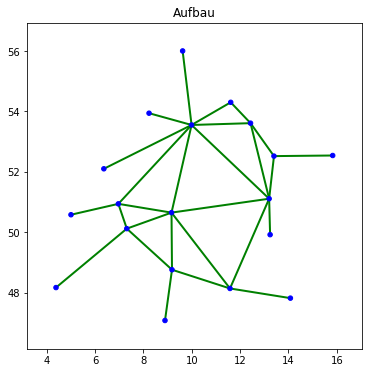

In [11]:
fig,ax=plt.subplots(1,1)
fig.set_size_inches(6,6)

nw.plot(bus_sizes=20, title="Aufbau")

### Generators

In [17]:
# only active generators
filtered = all_gens.loc[all_gens["Status 31.12.2016"]=="In Betrieb"]
# take the most powerful of each type of generator for each of the ÜNB
filtered = filtered.groupby([all_gens["Energieträger"], all_gens["ÜNB"]]).max()
# only 3 kinds of energysource
classic_gens = filtered[(filtered.Energieträger=="Braunkohle") | (filtered.Energieträger=="Steinkohle") | (filtered.Energieträger=="Erdgas")]
# get rid of multiple index columns
classic_gens.reset_index(drop=True, inplace=True)
# Vereinfachung der Indizes
classic_gens = classic_gens[["Betreiber", "Energieträger", "ÜNB", "Bundesland", "Nettoleistung 31.12.2016 [MW]"]].copy()

In [21]:
classic_gens

,name,carrier,ÜNB,Bundesland,p_nom,bus,committable
0,eins - energie in sachsen GmbH & Co. KG,Braunkohle,50Hertz,Sachsen-Anhalt,875.0,8,True
1,Smurfit Kappa Zülpich Papier GmbH,Braunkohle,Amprion,Nordrhein-Westfalen,1060.0,3,True
2,Städtische Werke Energie + Wärme GmbH,Braunkohle,TenneT,Hessen,33.5,5,True
3,envia THERM GmbH,Erdgas,50Hertz,Thüringen,444.0,8,True
4,ZF Friedrichshafen AG,Erdgas,Amprion,Saarland,595.0,4,True
5,Wacker Chemie AG,Erdgas,TenneT,Schleswig-Holstein,444.5,0,True
6,entfällt,Erdgas,TransnetBW,Baden-Württemberg,228.0,6,True
7,Vattenfall Heizkraftwerk Moorburg GmbH,Steinkohle,50Hertz,Schleswig-Holstein,800.0,0,True
8,WSW Energie & Wasser AG,Steinkohle,Amprion,Saarland,794.0,4,True
9,swb Erzeugung GmbH & Co. KG,Steinkohle,TenneT,Schleswig-Holstein,875.0,0,True


Add correct busnumber to each generator by comparing regions from df with buses

In [18]:
classic_gens["bus"] = 0

for j in range(len(classic_gens)):
    # find out index of "Bundesland" of each generator
    indices = [i for i, s in enumerate(nw.buses.name) if classic_gens["Bundesland"][j] in s]
    classic_gens.at[j, "bus"] = indices[0]

In [20]:
classic_gens.rename(columns={"Betreiber":"name",
                             "Energieträger":"carrier",
                             "Nettoleistung 31.12.2016 [MW]":"p_nom"}, inplace=True)
classic_gens["committable"] = True

In [22]:
pypsa.io.import_components_from_dataframe(nw, classic_gens, "Generator")

In [23]:
nw.generators

,name,carrier,ÜNB,Bundesland,p_nom,bus,committable,control,type,p_nom_extendable,...,start_up_cost,shut_down_cost,min_up_time,min_down_time,initial_status,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
0,eins - energie in sachsen GmbH & Co. KG,Braunkohle,50Hertz,Sachsen-Anhalt,875.0,8,True,PQ,,False,...,0.0,0.0,0,0,1,NaN,NaN,1.0,1.0,0.0
1,Smurfit Kappa Zülpich Papier GmbH,Braunkohle,Amprion,Nordrhein-Westfalen,1060.0,3,True,PQ,,False,...,0.0,0.0,0,0,1,NaN,NaN,1.0,1.0,0.0
2,Städtische Werke Energie + Wärme GmbH,Braunkohle,TenneT,Hessen,33.5,5,True,PQ,,False,...,0.0,0.0,0,0,1,NaN,NaN,1.0,1.0,0.0
3,envia THERM GmbH,Erdgas,50Hertz,Thüringen,444.0,8,True,PQ,,False,...,0.0,0.0,0,0,1,NaN,NaN,1.0,1.0,0.0
4,ZF Friedrichshafen AG,Erdgas,Amprion,Saarland,595.0,4,True,PQ,,False,...,0.0,0.0,0,0,1,NaN,NaN,1.0,1.0,0.0
5,Wacker Chemie AG,Erdgas,TenneT,Schleswig-Holstein,444.5,0,True,PQ,,False,...,0.0,0.0,0,0,1,NaN,NaN,1.0,1.0,0.0
6,entfällt,Erdgas,TransnetBW,Baden-Württemberg,228.0,6,True,PQ,,False,...,0.0,0.0,0,0,1,NaN,NaN,1.0,1.0,0.0
7,Vattenfall Heizkraftwerk Moorburg GmbH,Steinkohle,50Hertz,Schleswig-Holstein,800.0,0,True,PQ,,False,...,0.0,0.0,0,0,1,NaN,NaN,1.0,1.0,0.0
8,WSW Energie & Wasser AG,Steinkohle,Amprion,Saarland,794.0,4,True,PQ,,False,...,0.0,0.0,0,0,1,NaN,NaN,1.0,1.0,0.0
9,swb Erzeugung GmbH & Co. KG,Steinkohle,TenneT,Schleswig-Holstein,875.0,0,True,PQ,,False,...,0.0,0.0,0,0,1,NaN,NaN,1.0,1.0,0.0


Zuerst werden die zur Verfügung gestellten Daten eingelesen, danach werden diese noch um einige benötigte Werte von Hand erweitert, die zur Durchführung des Unit Commitment nötig sind

### Temporary Additional code
### ================================================

### ================================================

Einlesen der als *.csv gespeicherten Daten in ein pandas DataFrame, alle NaN werden durch 0 ersetzt

Uebertragen der Daten von pandas in das Netzwerk

In [ ]:
gen_temp_df = pd.DataFrame({1:gen_data[0], 2:gen_data[1]})

In [ ]:
pypsa.io.import_components_from_dataframe(nw, gen_temp_df.T, "Generator")

In [ ]:
gen_temp_df.T

In [ ]:
nw.add("Generator", "0",
       bus=2,
       carrier="wind",
       p_nom="3000",
       committable=True,
       efficiency=0.95,
       ramp_limit_up=100,
       ramp_limit_down=100,
       marginal_cost=5,
       p_min="5")

In [ ]:
# wind_temp_df

In [ ]:
nw.buses

In [ ]:
nw.lines

In [ ]:
nw.generators.T[["0", "1", "2"]]

Einlesen der Werte pro Zeitintervall

In [ ]:
wind_temp_df = pd.DataFrame({"0":wind_data_modell["Windeinspeisung Original"]})
wind_temp_df.index = nw.snapshots
# nw.import_series_from_dataframe(wind_temp_df, "Generator", "p_set")

In [ ]:
nw.generators_t.p_set["0"] = wind_temp_df["0"]

In [ ]:
load_temp_df = pd.DataFrame({"0":wind_data_modell["Last"]})
load_temp_df.index = nw.snapshots
# nw.import_series_from_dataframe(load_temp_df, "Load", "p_set")
nw.loads_t.p_set["0"] = load_temp_df["0"]

## Aufbereitung der Daten

In [ ]:
nw.lopf()

## Visualization

In [ ]:
gen_outs = nw.generators_t.p
caps_by_carrier = nw.generators.groupby("carrier")["p_nom"].sum()
gen_pot_remaining = nw.generators.p_nom - gen_outs

Line graph to display the dispatched amount of energy per plant

In [ ]:
gen_plot = gen_outs.plot(kind="area",grid=True)
lines, labels = gen_plot.get_legend_handles_labels()
gen_plot.legend(lines[:len(nw.generators)], nw.generators['name'].values.tolist(), loc='best')
plt.ylabel("MW")

network graph showing the distribution of buses etc.

In [ ]:
nw.generators_t.p_nom_opt